# Training and Testing MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import random
import cmath

# notes on comments: Q - Questions, A - Attention (to do, to pay attention to)

In [2]:
# BASIC FUNCTIONS

# lif neuron with noise (Gaussian)
def LIF_step_noise(voltage, tau, current, dt, threshold, voltage_rest, resistance, variance_noise):
    if voltage < threshold:
        return (- voltage + current * resistance + voltage_rest) * dt / tau + voltage + np.random.normal(0, variance_noise, 1)
    else:
        return voltage_rest + np.random.normal(0, variance_noise, 1)
    
#grad decent (real numbers), quadratic error function, target function: product
def weight_update(weights, x, y, mu): 
    #mu learning rate
    return weights + 2 * mu * (y - np.dot(weights, x)) * x

#delay function (one step)
def delay_update(x, y): 
    return y - x

#grad decent (real numbers), quadratic error function, target function: sum
def delay_update_2(delays, x, y, mu): 
    #shape of delays: (neurons,)
    #mu learning rate
    return delays + 2 * mu * (y - (x + delays)) #ATTENTION: Y is a scalar, x and delays are vectors (but it works)!!!

#(complex) phase
def convert_phase(T, t):
    return math.pi * t / (T * 2) 

# time from (complex) phase
def convert_phase_back(T, phi):
    return phi * 2 * T / math.pi

# complex exponential for arrays
def convert_exp(array): 
    res = np.zeros(len(array), dtype=np.complex_)
    for a in range(len(array)):
        res[a] = cmath.exp(array[a])
    return res

# get phase, if negative convert to a positive number (3/4th quarter complex plane) -- not used (all results should be WITHIN 2 T_MAX)
def phase_2pi(complex_number):
    res = cmath.phase(complex_number)
    if res < 0: return (2 * math.pi + res)
    else: return res
    
# get also negative weights (3rd/4th quadrant complex space)
def real_phase(complex_number):
    res = cmath.phase(complex_number)
    if res < 0: 
        return (math.pi + res)
    else:
        return res
# get also negative weights (3rd/4th quadrant complex space)

def real_weights(complex_number):
    res = cmath.phase(complex_number)
    if res < 0: 
        return -abs(complex_number)
    else:
        return abs(complex_number)

# convert data to complex numbers (e.g. xdata)
def data_complex(neurons, X_delays, X_weights):
    # for one training/test example only (one value per neuron)
    complex_X = np.zeros((neurons, 1), dtype=np.complex_) # (neurons, 1) to make module 1 work
    for a in range(neurons):
        complex_X[a, 0] = cmath.exp(complex(0, 1) * convert_phase(t_max, X_delays[a])) * X_weights[a]
    return complex_X

In [3]:
# PARAMETER SETTINGS LIF NEURON

# THESIS: TWO DIFFERENT TAU 

dt = 0.001
tau = 5 # 27 / 2 
voltage_rest = 0
resistance = 1
variance_noise = 0.0 #variance Gaussian LIF neuron noise
learning_rate = 0.0001

feature_ = 100 * 3

In [4]:
# MODULE 2 - TRAINING DELAYS AND WEIGHTS FOR THE GIVEN PATTERN

# module_2: grad decent on one specific pattern until convergence
# module_2_2: grad decent with different training examples every step ('noisy')
# module_2_2: mini batch grad descent (one training example per step)
# module_2_3: mini batch grad descent for multiple postsyn neurons (first iterate over postsyn neurons, then over training data)
# module_2_3: adapted to data structure mnist

# Q: 'noisy' training: no noise on 0 !?, learning rate changes results dynamically

def module_2_3 (X_delays, X_weight, labels, learning_rate, iterations, neurons_pre, neurons_post):
    # array labels contains Y data (size_dataset x postsyn. neurons x 2)
    # index X data and Y data always minus one because otherwise first training example is not used !!
    d_evolution = np.zeros((neurons_post, neurons_pre, iterations + 1, 2))
    for a in range(iterations + 1):
        # first iteration: write everywhere zero (no change)
        for b in range(neurons_post):
            if a > 0:
                d_evolution[b, :, a, 1] = delay_update_2(d_evolution[b, :, a - 1, 1], X_delays[:, a - 1], labels[a - 1, b, 1], learning_rate)
                d_evolution[b, :, a, 0] = weight_update(d_evolution[b, :, a - 1, 0], X_weight[:, a - 1], labels[a - 1, b, 0], learning_rate)
    return d_evolution

# READ TRAINING DATA

In [5]:
# READ MNIST TRAINING DATA (X ONLY) AND DISPLAY

spikes = np.load('comp_serv/features/spikes_all_.txt.npy')

spike_times = np.load('comp_serv/features/spike_times_all_.txt.npy')
spike_weights = np.load('comp_serv/features/spike_weights_all_.txt.npy')

# PARAMETERS FROM TRAINING DATA

size_dataset = np.shape(spike_times)[0] #data set MNIST test digit, only binary spikes (no difference in weight!)
neurons_pre = np.shape(spike_times)[1] # presyn neurons
t_max = np.shape(spikes)[2] # t_max is the whole 'spike train' (left to right)

In [6]:
# READ MNIST TRAINING DATA (Y ONLY) AND TRANSFORM THEM IN (WEIGHT, DELAY)

neurons_post = 10 # postsyn neurons

labels = np.loadtxt('comp_serv/features/indices_all.txt') # numbers between 0 and 9

labels_post = np.zeros((size_dataset, neurons_post, 2))

for a in range(size_dataset):
    #labels_post[a, :, 0] = 0.1
    labels_post[a, int(labels[a]), 0] = 1 # assign a weight of one to the postsyn neuron
    labels_post[a, :, 1] = t_max + t_max / 2
    #labels_post[a, int(labels[a]), 1] = t_max + t_max / 2  # assign postsyn spike time ATTENDION !!!!!

# TRAIN DATA

## GRADIENT DESCENT

In [7]:
# GRADIENT DESCENT TRAINING (MODULE 2)

# Q: parameters noise, noise on the weights

iterations = size_dataset #one iteration grad decent per training example

delays = np.transpose(spike_times[:, :feature_]) # (neurons x examples)
weights = np.transpose(spike_weights[:, :feature_]) # (neurons x examples)

result_all = module_2_3(delays, weights, labels_post, learning_rate, iterations, feature_, neurons_post)
print(np.shape(result_all))

(10, 300, 60001, 2)


## LINEAR ALGEBRA

In [8]:
# MODULE 1 - LINEAR ALGEBRA (LA) TO SOLVE LIN EQUATION (on complex data)

def module_1 (complex_X, complex_Y):
    return np.dot(np.linalg.pinv((complex_X)),(complex_Y))

In [9]:
X_matrix = np.zeros((feature_, iterations), dtype=np.complex_)
Y_matrix = np.zeros((neurons_post, iterations), dtype=np.complex_)

for a in range(iterations):
    # convert training data to complex numbers
    # delays (neurons x examples)
    # weights (neurons x examples)
    for b in range(neurons_post):
        Y_matrix[b, a] = (cmath.exp(complex(0, 1) * convert_phase(t_max, labels_post[a, b, 1])) * labels_post[a, b, 0])
    X_matrix[:, a] = data_complex(feature_, delays[:, a], weights[:, a])[:, 0]
    
X_new = np.transpose(X_matrix)
Y_new = np.transpose(Y_matrix)

complex_result_all = module_1(X_new, Y_new)

In [10]:
print(np.shape(complex_result_all))

(300, 10)


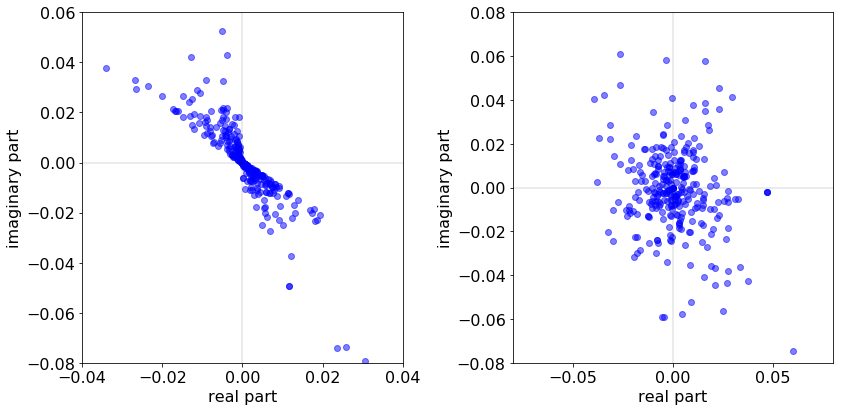

In [11]:
result_display = result_all[0, :,iterations, :]

plt.figure(figsize = (12, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# complex plane
# convert to complex numbers (res)
plt.subplot(1, 2, 1)
res = result_display[:, 0] * convert_exp(complex(0, 1) * convert_phase(t_max, result_display[:, 1]))
plt.plot(res.real, res.imag, 'bo', alpha = 0.5)
#plt.plot(res[iterations].real, res[iterations].imag, 'o', color=color)
plt.axvline(0, color = 'k', alpha = 0.1)        
plt.axhline(0, color = 'k', alpha = 0.1)
plt.xlabel('real part')
plt.ylabel('imaginary part')
plt.xlim(-0.04, 0.04)
plt.ylim(-0.08, 0.06)

plt.subplot(1, 2, 2)
plt.plot(complex_result_all[:, 0].real, complex_result_all[:, 0].imag, 'bo', alpha = 0.5)
plt.axvline(0, color = 'k', alpha = 0.1)        
plt.axhline(0, color = 'k', alpha = 0.1)
plt.xlabel('real part')
plt.ylabel('imaginary part')
plt.xlim(-0.08, 0.08)
plt.ylim(-0.08, 0.08)

plt.tight_layout()
#plt.savefig('weights_space.pdf')
plt.show()

# READ TESTING DATA

In [12]:
# READ MNIST TEST DATA 

spike_times_test = np.load('comp_serv/features/spike_times_all_test_.txt.npy') # (examples x neurons)
spike_weights_test = np.load('comp_serv/features/spike_weights_all_test_.txt.npy') # (examples x neurons)

delays_test = np.transpose(spike_times_test[:, :feature_])
weights_test = np.transpose(spike_weights_test[:, :feature_])

neurons_post = 10 # postsyn neurons

labels_test = np.loadtxt('comp_serv/features/indices_all_test.txt') # numbers between 0 and 9

size_dataset_test = np.shape(spike_times_test)[0]
print(size_dataset_test)

10000


# TEST DATA

## GRADIENT DESCENT
### complex plane postsynaptic weights

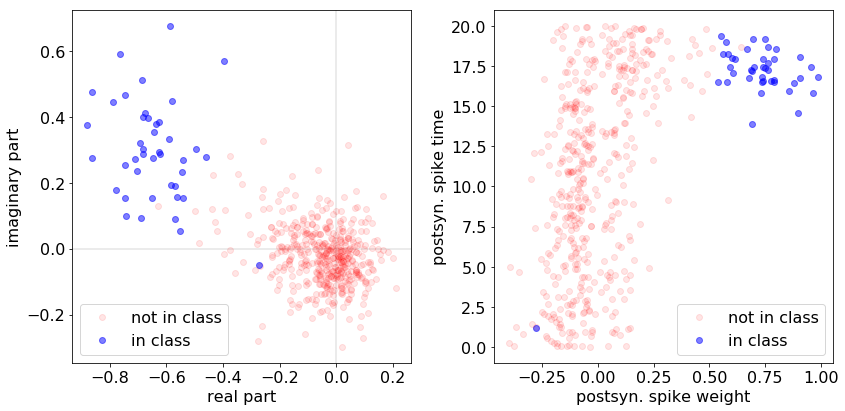

In [13]:
# PLOT COMPLEX WEIGHT (SPIKES) POST (PRE X TRAINED WEIGHT) GRAD DESCENT APPROACH

test_range = 500

complex_weights_post = np.zeros((neurons_post, size_dataset_test), dtype=np.complex_)

for b in range(neurons_post):
    # get complex numbers from grad descent
    res = result_all[b, :, iterations, 0] * convert_exp(complex(0, 1) * convert_phase(t_max, result_all[b, :, iterations, 1]))
    for a in range(test_range):
        # convert data to complex numbers
        complex_weights_pre = data_complex(feature_, delays_test[:, a], weights_test[:, a])
        complex_weights_post[b, a] = np.dot(res, complex_weights_pre)
    
x_ = np.zeros((neurons_post, test_range))
y_ = np.zeros((neurons_post, test_range))

plt.figure(figsize = (12, 6))

plt.rcParams.update({'font.size': 16}) #change font size for figures

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

zae = 0
zae_2 = 0
zae_3 = 0
zae_4 = 0

for b in range(1):
    plt.subplot(1, 2, 2)
    plt.xlabel('postsyn. spike weight')
    plt.ylabel('postsyn. spike time')
    for a in range(test_range):
        x_[b, a] = real_weights(complex_weights_post[b, a])
        y_[b, a] = convert_phase_back(t_max, real_phase(complex_weights_post[b, a]))
        # REAL PLANE (WEIGHT X DELAY)
        if labels_test[a] == b:
            zae_3 = zae_3 + 1
            if zae_3 == 1:
                plt.plot(x_[b, a] , y_[b, a] , 'bo', alpha = 0.5, label = 'in class')
            else:
                plt.plot(x_[b, a] , y_[b, a] , 'bo', alpha = 0.5)

        else:
            zae_4 = zae_4 + 1
            if zae_4 == 1:
                plt.plot(x_[b, a] , y_[b, a], 'ro', alpha = 0.1, label = 'not in class')
            else:
                plt.plot(x_[b, a] , y_[b, a], 'ro', alpha = 0.1)
    plt.legend()
    
    plt.subplot(1, 2, 1)
    plt.axvline(0, color = 'k', alpha = 0.1)        
    plt.axhline(0, color = 'k', alpha = 0.1)
    plt.xlabel('real part')
    plt.ylabel('imaginary part')
    for a in range(test_range):
        x_[b, a] = real_weights(complex_weights_post[b, a])
        y_[b, a] = convert_phase_back(t_max, real_phase(complex_weights_post[b, a]))
        # COMPLEX PLANE (REAL X IMAG)
        if labels_test[a] == b:
            zae = zae + 1
            if zae == 1:
                plt.plot(complex_weights_post[b, a].real, complex_weights_post[b, a].imag, 'bo', alpha = 0.5, label = 'in class')
            else:
                plt.plot(complex_weights_post[b, a].real, complex_weights_post[b, a].imag, 'bo', alpha = 0.5)
        else:
            zae_2 = zae_2 + 1
            if zae_2 == 1:
                plt.plot(complex_weights_post[b, a].real, complex_weights_post[b, a].imag, 'ro', alpha = 0.1, label = 'not in class')
            else:
                plt.plot(complex_weights_post[b, a].real, complex_weights_post[b, a].imag, 'ro', alpha = 0.1)
    plt.legend()

plt.tight_layout()
#plt.savefig('predicted_module_2.pdf')
plt.show()

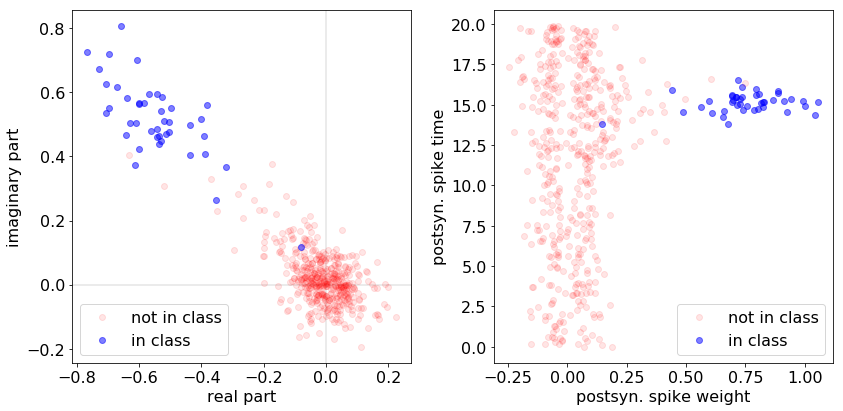

In [14]:
# PLOT COMPLEX WEIGHT POST (PRE X TRAINED WEIGHT) LA APROACH

plt.figure(figsize = (12, 6))

plt.rcParams.update({'font.size': 16}) #change font size for figures

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

complex_weight_post_la = np.zeros((size_dataset_test), dtype=np.complex_)
complex_result_all_transposed = np.transpose(complex_result_all)

test_range = 500

zae = 0
zae_2 = 0
zae_3 = 0
zae_4 = 0

for b in range(1):
    plt.subplot(1, 2, 2)
    plt.xlabel('postsyn. spike weight')
    plt.ylabel('postsyn. spike time')
    for a in range(test_range):
        # REAL PLANE (WEIGHT X DELAY)
        # convert X data to complex numbers
        complex_weight_pre = data_complex(feature_, delays_test[:, a], weights_test[:, a]) 
        complex_weight_post_la[a] = np.dot(complex_result_all_transposed[b, :], complex_weight_pre) # check dimensionality ?!
        if labels_test[a] == b:
            zae = zae + 1
            if zae == 1:
                plt.plot(real_weights(complex_weight_post_la[a]), convert_phase_back(t_max, real_phase(complex_weight_post_la[a])), 'bo', alpha = 0.5, label = 'in class')
            else:
                plt.plot(real_weights(complex_weight_post_la[a]), convert_phase_back(t_max, real_phase(complex_weight_post_la[a])), 'bo', alpha = 0.5)

        else:
            zae_2 = zae_2 + 1
            if zae_2 == 1:
                plt.plot(real_weights(complex_weight_post_la[a]), convert_phase_back(t_max, real_phase(complex_weight_post_la[a])), 'ro', alpha = 0.1, label = 'not in class')
            else:
                plt.plot(real_weights(complex_weight_post_la[a]), convert_phase_back(t_max, real_phase(complex_weight_post_la[a])), 'ro', alpha = 0.1)
    plt.legend(loc = 4)
    plt.subplot(1, 2, 1)
    plt.axvline(0, color = 'k', alpha = 0.1)        
    plt.axhline(0, color = 'k', alpha = 0.1)
    plt.xlabel('real part')
    plt.ylabel('imaginary part')
    for a in range(test_range):
        # COMPLEX PLANE (REAL X IMAG)
        if labels_test[a] == b:
            zae_3 = zae_3 + 1
            if zae_3 == 1:
                plt.plot(complex_weight_post_la[a].real, complex_weight_post_la[a].imag, 'bo', alpha = 0.5, label = 'in class')
            else:
                plt.plot(complex_weight_post_la[a].real, complex_weight_post_la[a].imag, 'bo', alpha = 0.5)
        else:
            zae_4 = zae_4 + 1
            if zae_4 == 1:
                plt.plot(complex_weight_post_la[a].real, complex_weight_post_la[a].imag, 'ro', alpha = 0.1, label = 'not in class')
            else:
                 plt.plot(complex_weight_post_la[a].real, complex_weight_post_la[a].imag, 'ro', alpha = 0.1)
    plt.legend(loc = 3)

plt.tight_layout()
#plt.savefig('predicted_module_1.pdf')
plt.show()

## GRADIENT DESCENT
### statistics membrane potential (no threshold)

In [15]:
# MAX MEMBRANE VOLTAGES (NO CUTTING AT THRESHOLD)

# A: decay (time) parameter = t_max (now) / 2 (independence assumption)

# Q: time resolution of the simulation
# Q: scaling of the weights (to compensate noise e.g.)

time_max = t_max * 4 # max time of the simulation
repetitions = 1 # number of repetitive calc. postsyn. potential

test_range = 500
currents_max = np.zeros((test_range, neurons_post))
spike_label = np.zeros((neurons_post, size_dataset_test))

max_voltage = np.zeros((test_range, neurons_post, 2)) 

for test in range(test_range):
    
    #membrane voltage postsyn
    voltage_steps = np.zeros((neurons_post, int(time_max/dt), repetitions))

    #input current (determined by spikes and respective delays) - postsyn.
    current_postsyn = np.zeros((neurons_post, int(time_max / dt))) 

    #input current (determined by spikes) - presyn.
    current_presyn = np.zeros((neurons_post, int(time_max / dt))) 

    #times of spikes postsyn, using result grad decent mini-batch
    #round spike times with a precision of 3 decimal numbers (corresponds to a resolution of 0.001)
    spike_times_post = np.zeros((neurons_post, feature_)) 

    for a in range(neurons_post):
        spike_times_post[a, :] = delays_test[:, test] + result_all[a, :, iterations, 1]
        spike_times_post[a, :] = np.round(np.sort(spike_times_post[a, :]), decimals = 3)

        #input current post
        for b in range(feature_):
            if current_postsyn[a, int(spike_times_post[a, b] / dt)] == 0: 
                current_postsyn[a, int(spike_times_post[a, b] / dt)] = result_all[a, b, iterations, 0] * weights_test[b, test] * tau / dt
            else: 
                current_postsyn[a, int(spike_times_post[a, b] / dt)] = current_postsyn[a, int(spike_times_post[a, b] / dt)] + result_all[a, b, iterations, 0] * weights_test[b, test] * tau / dt
        currents_max[test, a] = np.max(current_postsyn[a, :])

        #membrane potential
        #repetition: compute membrane potential several times as it is stochastic (noise)
        for c in range(repetitions):
            for d in range(int(time_max / dt)):
                if d == 0:
                    voltage_steps[a, d, c] = voltage_rest
                if d > 0:
                    voltage_steps[a, d, c] = LIF_step_noise(voltage_steps[a, d - 1, c], tau, current_postsyn[a, d], dt, 5, voltage_rest, resistance, variance_noise)
        # safe max voltage (one test example individual for every postsyn neuron)            
        max_voltage[test, a, 0] = np.max(voltage_steps[a, :, c])
        if labels_test[test] == a: max_voltage[test, a, 1] = 1

### extract threshold

In [16]:
# extract number of items per class (0...9)
items = np.zeros(10) # stores number of items per class
for a in range(test_range):
    for b in range(10):
        if labels_test[a] == b:
            items[b] = items[b] + 1
print(items)

[42. 67. 55. 45. 55. 50. 43. 49. 40. 54.]


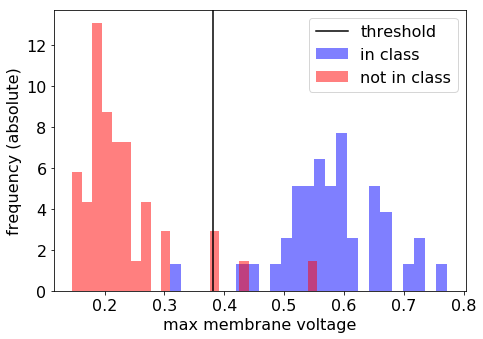

In [18]:
# HISTOGRAM MAX MEMBRANE VOLTAGES

# Q: why no neg voltages ?

plt.figure(figsize = (7,5))
plt.rcParams.update({'font.size': 16}) #change font size for figures

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

threshold_list = []

for h in range(neurons_post):
    list_class = []
    list_no_class = []
    # sort max voltages in lists according to their label 'belongs to class or not' (ONE POSTSYN NEURON: 0 / 1)
    for i in range(test_range):
        if max_voltage[i, h, 1] == 1:
            list_class.append(max_voltage[i, h, 0])
        else:
            list_no_class.append(max_voltage[i, h, 0])
    
    # write the same number of items each class in an array (ONE POSTSYN NEURON: 0 / 1)
    list_ = np.zeros((int(items[h] * 2), 2))
    list_[:int(items[h]), 0] = list_class
    list_[:int(items[h]), 1] = 1
    list_[int(items[h]):, 0] = list_no_class[:int(items[h])]
    
    sort_list = list_[np.argsort(list_[:, 0]), :]
    threshold_ = 0
    a = np.count_nonzero(list_[:, 1]) # count correct classification of 1s. Initially vth = 0, so always true
    b = 0 # count correct classification of 0s. Initially always wrong
    max_c = a + b  # number of right classifications
    for i, vl in enumerate(sort_list):
        if vl[1] == 0: #meaning that this input is not in the class
            b += 1   #this input would be correctly classified if vth = vl[0]
        else:
            a -= 1
        c = a + b
        if c > max_c:
            threshold_ = vl[0]
            max_c = c
    threshold_list.append(threshold_)  
   
    #plt.subplot(3, 4, h + 1)    
    if h == 0:
        n_2, bins_2, patches_2 = plt.hist(list_[:int(items[h]), 0], 25, normed = 1, facecolor='blue', alpha=0.5, label = 'in class')
        n, bins, patches = plt.hist(list_[int(items[h]):, 0], 25, normed = 1, facecolor='red', alpha=0.5, label = 'not in class')
        plt.axvline(threshold_list[h], color = 'black', label = 'threshold')
        plt.xlabel('max membrane voltage')
        plt.ylabel('frequency (absolute)')
        plt.legend()
    
plt.tight_layout()
#plt.savefig('threshold_extraction_threshold5.pdf')
plt.show()